# Neural network regression

We will be using the `scikit-learn` library to train neural networks. While there are deep learning libraries which offer advanced functionality, the neural network implementation in `scikit-learn` covers all the cases we are going to encounter in this course, and does much more. Moreover, its training and prediction procedures are very straightforward.

There are two classes in the `sklearn.neural_network` module - `MLPRegressor` and `MLPClassifier` for regression and classification tasks respectively. This week, we will be covering the `MLPRegressor` class. In this notebook, we will be training a neural network regression model on the concrete dataset discussed in class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")
crt.head()

,Cement,Slag,FlyAsh,Water,SPlast,CAgg,FAgg,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
# standardize predictors
X = crt.drop('Strength',axis=1).values # extract as numpy ndarray
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

# standardize response
y = crt['Strength'].values
y_mean,y_std = y.mean(),y.std()
y = (y-y_mean)/y_std

## `MLPRegressor` class

Some differences from `nnet` (for regression):

- Can construct multiple hidden layers.
- Supports two more nonlinear activation functions for the hidden layers: `relu` and `tanh`. `nnet` supports only `logistic` activation. 
$$
\begin{aligned}
    \mathrm{logistic}(x) &= \frac{1}{1+ e^{-x}} \\
    \mathrm{tanh}(x) &= \frac{e^x - e^{-x}}{e^x + e^{-x}} = 2*\mathrm{logistic}(2x)-1\\ 
    \mathrm{relu}(x) &= \max(0,x) 
\end{aligned}
$$

- Has support for stochastic gradient optimization (relevant only for large datasets). 
- **Does not** support skip-layer connections from input to output.

In this notebook, we will use only those options available to both `nnet` and `MLPRegressor` - single hidden layer, logistic activation function for the hidden layer, and standard non-linear optimization.

In [5]:
# Neural network regression model
from sklearn.neural_network import MLPRegressor

print(MLPRegressor.__doc__)

Multi-layer Perceptron regressor.

    This model optimizes the squared-loss using LBFGS or stochastic gradient
    descent.

    .. versionadded:: 0.18

    Parameters
    ----------
    hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
        The ith element represents the number of neurons in the ith
        hidden layer.

    activation : {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
        Activation function for the hidden layer.

        - 'identity', no-op activation, useful to implement linear bottleneck,
          returns f(x) = x

        - 'logistic', the logistic sigmoid function,
          returns f(x) = 1 / (1 + exp(-x)).

        - 'tanh', the hyperbolic tan function,
          returns f(x) = tanh(x).

        - 'relu', the rectified linear unit function,
          returns f(x) = max(0, x)

    solver : {'lbfgs', 'sgd', 'adam'}, default='adam'
        The solver for weight optimization.

        - 'lbfgs' is an optimizer in the family of qua

In [6]:
# define a neural network model
nn1 = MLPRegressor(
    hidden_layer_sizes=10, # scalar -> single hidden layer with 10 units
    activation='logistic', # activation function for the hidden layer (not the default)
    solver='lbfgs', # deterministic optimizer (not the default)
    alpha=0.01,# regularization parameter
    max_iter = 1000 # number of optimization iterations
)

# fit model
_ = nn1.fit(X,y)

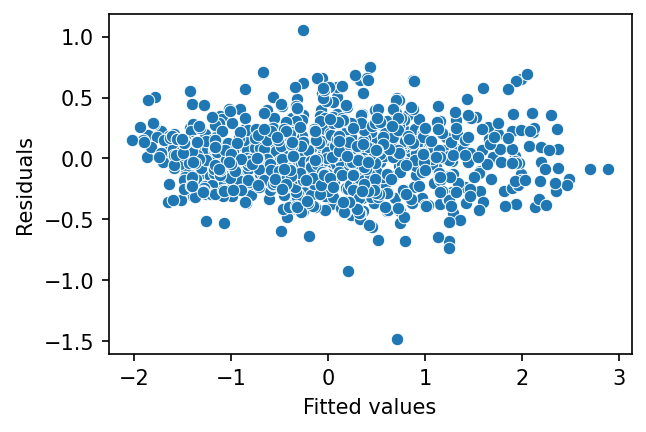

In [7]:
# computing predictions on training set
y_pred = nn1.predict(X)
# residuals
e = y-y_pred

# quick diagnostic -  residual vs fitted
fig,axs = plt.subplots(1,1,figsize=(4.5,3))
_ = sns.scatterplot(x=y_pred,y=e,ax=axs)
_ = axs.set_xlabel('Fitted values')
_ = axs.set_ylabel('Residuals')

In [8]:
# training metrics
training_r2 = 1 - np.mean(e**2)/y.var()
training_r2

0.9379283315650475

In [15]:
nn1.coefs_[0]

array([[-4.41713603e-01, -7.14800498e-01, -3.44556091e+00,
        -1.09324791e+00,  3.42313042e-01, -5.86772367e-01,
        -2.66038140e+00,  1.18725191e+00, -1.39067097e+00,
        -1.03287317e-01],
       [-9.07985979e-01, -4.30629155e-01, -1.96073491e+00,
        -5.89726305e-01, -2.80435604e-01, -6.30299304e-01,
        -2.92005366e+00,  9.04426780e-01, -1.66737431e+00,
         4.59840920e-01],
       [-1.66596980e+00, -1.53247323e-02, -6.32150266e-01,
        -2.25594431e-01, -1.22376310e+00, -4.12834515e-01,
        -1.25152239e+00, -1.99161004e+00, -4.67863140e+00,
         8.57101323e-02],
       [-2.08406473e+00,  3.91611795e+00, -1.25056201e+00,
        -6.52396622e-01, -2.43942993e+00,  1.28310319e-01,
        -2.45604937e+00,  4.10825027e-01, -1.38992378e+00,
         2.26807616e+00],
       [ 6.47011728e-01,  2.11785990e-01, -1.17192868e+00,
         3.97885565e-03,  9.76236746e-01,  9.93396550e-02,
         6.95757544e-01, -1.88882044e+00, -7.24405320e-01,
        -1.

### Tuning hyperparameters via grid search

Two hyperparameters to tune 

- Number of units in the hidden layer, `hidden_layer_sizes` (we will be using only a single hidden layer)
- Regularization penalty, `alpha`

In [16]:
# for generating combinations
from itertools import product

# create grid of hyperparameters
alphas = [0.01,0.1,1] # 3 values for alpha
sizes = [5,10,20,30] # 4 values for the number of units

configs = list(product(alphas,sizes)) # 12 different combinations
configs

[(0.01, 5),
 (0.01, 10),
 (0.01, 20),
 (0.01, 30),
 (0.1, 5),
 (0.1, 10),
 (0.1, 20),
 (0.1, 30),
 (1, 5),
 (1, 10),
 (1, 20),
 (1, 30)]

In [17]:
# Model validation 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error # CV loss metric
from sklearn.base import clone # create a copy of the model

In [18]:
# Hyper-parameter tuning via cross-validation for scikit-learn estimators

# initial model object
nn_init = MLPRegressor(
    hidden_layer_sizes=10,
    activation='logistic',
    solver='lbfgs',
    alpha=0.01,
    max_iter = 1000
)


# 5 fold CV

np.random.seed(456)
n_folds = 5
kf = KFold(n_splits=n_folds,shuffle=True)

# matrix of mses
# rows - folds
# columns - hyperparameter configurations
mses = np.empty((n_folds,len(alphas)*len(sizes)))


for i,(train_index,test_index) in enumerate(kf.split(X)):
    # outer for loop is over fold: different train-test-splits
    for j,(alpha,size) in enumerate(configs):
        # inner loop is over different hyperparameter configurations
        
        # create new model by clonining the initial object with the specified hyperparameters
        nn_fold = clone(nn_init).set_params(alpha=alpha,hidden_layer_sizes=size)
        
        # fit model on training split
        _ = nn_fold.fit(X[train_index,:],y[train_index])
        
        # compute test predictions
        y_test_pred = nn_fold.predict(X[test_index,:])
        # compute metric-mean-squared error
        mses[i,j] = mean_squared_error(y[test_index],y_test_pred)

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

In [19]:
with np.printoptions(formatter={'float':lambda x: '%6.3f'%x},linewidth=100):
    print(mses)

[[ 0.096  0.097  0.047  0.052  0.118  0.079  0.059  0.059  0.128  0.106  0.106  0.105]
 [ 0.127  0.101  0.104  0.091  0.133  0.107  0.077  0.089  0.143  0.132  0.129  0.127]
 [ 0.122  0.107  0.085  0.131  0.141  0.120  0.102  0.102  0.143  0.137  0.138  0.135]
 [ 0.119  0.115  0.078  0.147  0.141  0.126  0.110  0.119  0.147  0.147  0.145  0.148]
 [ 0.137  0.095  0.112  0.091  0.112  0.103  0.101  0.107  0.146  0.146  0.142  0.144]]


In [20]:
mse_cv = mses.mean(axis=0)

with np.printoptions(formatter={'float':lambda x: '%6.3f'%x},linewidth=100):
    print(mse_cv)

[ 0.120  0.103  0.085  0.102  0.129  0.107  0.090  0.095  0.142  0.134  0.132  0.132]


In [21]:
mse_cv = mses.mean(axis=0)
r2_cv = 1-mse_cv/y.var() # convert mean-squared error to R2

with np.printoptions(formatter={'float':lambda x: '%6.3f'%x},linewidth=100):
    print(r2_cv)

[ 0.880  0.897  0.915  0.898  0.871  0.893  0.910  0.905  0.858  0.866  0.868  0.868]


In [22]:
r2_cv_formatted = pd.DataFrame([{
    'alpha':configs[i][0],'size':configs[i][1],
    'r2_cv':r2_cv[i]
} for i in range(len(configs))])
r2_cv_formatted.round(3).sort_values('r2_cv',ascending=False)

,alpha,size,r2_cv
2,0.01,20,0.915
6,0.10,20,0.910
7,0.10,30,0.905
3,0.01,30,0.898
1,0.01,10,0.897
5,0.10,10,0.893
0,0.01,5,0.880
4,0.10,5,0.871
10,1.00,20,0.868
11,1.00,30,0.868


In [23]:
# best configuration
idx_best = r2_cv.argmax()
configs[idx_best]

(0.01, 20)

### Final model

In [24]:
# define a neural network model
nn_final = clone(nn_init).set_params(alpha=0.01,hidden_layer_sizes=20)

# fit model
_ = nn_final.fit(X,y)

# computing predictions on training set
y_pred = nn_final.predict(X)
# residuals
e = y-y_pred

# training metrics
training_r2 = 1 - np.sum(e**2)/np.sum(y**2)
print('Training R2: %.3f'%training_r2)

Training R2: 0.965


/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Grid-search via scikit-learn

Scikit-learn provides a convenient class for performing grid search - `GridSearchCV` and fitting the final model in one go.

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
%%time 

np.random.seed(456)
nn_tuned = GridSearchCV(
    estimator=nn_init,
    param_grid={ # dictionary containing possible values of each hyperparameter
        'alpha':alphas,
        'hidden_layer_sizes':sizes,
    },
    scoring='neg_mean_squared_error', # score (higher is better) - negative loss 
    refit=True, # whether to fit the model with the best configuration on the entire training set.
    cv=kf, # cross-validation split generator
    n_jobs=1, # argument for utilizing parallel cores
).fit(X,y)

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

CPU times: user 1min, sys: 23 s, total: 1min 23s
Wall time: 19.3 s


/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [27]:
nn_tuned.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': 20}

In [28]:
# best 5-fold CV R2
print('CV R2: %.3f'%(1-(-nn_tuned.best_score_)/y.var()))

CV R2: 0.917


In [30]:
nn_tuned.cv_results_

{'mean_fit_time': array([0.1686358 , 0.32370605, 0.4819665 , 0.58726764, 0.10767722,
        0.19965701, 0.49570637, 0.62067032, 0.0798769 , 0.14392886,
        0.21241465, 0.30485015]),
 'std_fit_time': array([0.03994919, 0.00488291, 0.00665067, 0.00446173, 0.034005  ,
        0.01914332, 0.01819105, 0.01525294, 0.01559987, 0.04864134,
        0.04533696, 0.08803463]),
 'mean_score_time': array([0.00029702, 0.00047841, 0.00066204, 0.00066824, 0.00028119,
        0.00031824, 0.00060511, 0.00070596, 0.00036016, 0.00036907,
        0.00038624, 0.0004046 ]),
 'std_score_time': array([8.50509618e-06, 7.76329262e-05, 3.67756775e-05, 1.78463274e-05,
        1.88532271e-05, 3.80835602e-05, 1.34089882e-04, 3.25823218e-05,
        1.37620194e-05, 2.12805110e-05, 1.28277172e-05, 2.50768294e-05]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, 

The optimal regularization hyperparameter is different from earlier, and the best CV $R^2$ is slightly different. Even accounting for the same K-fold partition, there will be some randomness in the results due to random initialization of the weights of the network. 

In [29]:
# computing predictions on training set
y_pred = nn_tuned.predict(X)
# residuals
e = y-y_pred

# training metrics
training_r2 = 1 - np.sum(e**2)/np.sum(y**2)
print('Training R2: %.3f'%training_r2)

Training R2: 0.955


### Comparing with other models

When comparing models using cross-validation, either

1. use the **same** K-fold partition, if using a single replicate of K-fold
2. perform Replicated K-fold CV


We now compare the neural network model against a linear regression model.

In [31]:
import statsmodels.api as sm

In [32]:
############ linear regression model ############
mses_lm_kf = np.empty(n_folds)

for i,(train_index,test_index) in enumerate(kf.split(X)):
    
    # fit OLS model on the entire training set excluding the current fold
    fit_lm = sm.OLS(y[train_index],sm.add_constant(X[train_index,:])).fit()
    
    # obtain out-of-sample predictions for the current fold
    y_pred_lm = fit_lm.predict(sm.add_constant(X[test_index,:]))
    
    # compute loss metric - mean_squared error
    mses_lm_kf[i] = mean_squared_error(y[test_index],y_pred_lm)
    
    
mse_lm_cv = mses_lm_kf.mean()
r2_lm_cv = 1-mse_lm_cv/y.var() 

print('5-fold CV R2 for neural network.....: %5.3f'%r2_cv[idx_best])
print('5-fold CV R2 for linear regression..: %5.3f'%r2_lm_cv)

5-fold CV R2 for neural network.....: 0.915
5-fold CV R2 for linear regression..: 0.606


Likewise, here is the loop for performing replicated 5-fold CV. This time, we need to compute the replicated CV metric for the neural network as well, since we haven't computed it earlier.

In [33]:
from sklearn.model_selection import RepeatedKFold

# cross-validation measure for comparison with other models
# 5 replicates of 5 fold cross-validation
np.random.seed(234)

n_repeats=5
rkf = RepeatedKFold(n_splits=n_folds,n_repeats=n_repeats)
mses_nnet_rkf = np.empty(n_folds*n_repeats)
mses_lm_rkf = np.empty(n_folds*n_repeats)

for i,(train_index,test_index) in enumerate(rkf.split(X)):
    ############ neural network model ############
    # create new model with the specified hyperparameters
    nn_fold = clone(nn_init).set_params(alpha=0.1,hidden_layer_sizes=20)

    # fit model on training split
    _ = nn_fold.fit(X[train_index,:],y[train_index])

    # compute test predictions
    y_pred_nnet = nn_fold.predict(X[test_index,:])
    # compute metric-mean-squared error
    mses_nnet_rkf[i] = mean_squared_error(y[test_index],y_pred_nnet)
    
    ############ linear regression model ############
    # fit OLM model
    fit_lm = sm.OLS(y[train_index],sm.add_constant(X[train_index,:])).fit()
    y_pred_lm = fit_lm.predict(sm.add_constant(X[test_index,:]))
    mses_lm_rkf[i] = mean_squared_error(y[test_index],y_pred_lm)

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

In [35]:
mse_nnet_cv = mses_nnet_rkf.mean()
mse_lm_cv = mses_lm_rkf.mean()

r2_nnet_cv = 1-mse_nnet_cv/y.var()
r2_lm_cv = 1-mse_lm_cv/y.var()

print('Replicated 5-fold CV R2 for neural network.....: %5.3f'%r2_nnet_cv)
print('Replicated 5-fold CV R2 for linear regression..: %5.3f'%r2_lm_cv)

Replicated 5-fold CV R2 for neural network.....: 0.907
Replicated 5-fold CV R2 for linear regression..: 0.607


## Saving models and other objects

In [36]:
import joblib

In [37]:
# joblib save model
_ = joblib.dump(nn_final,'crt_nnet_final.pkl')

In [38]:
# joblib.load
nn_final2 = joblib.load('crt_nnet_final.pkl')
nn_final2

MLPRegressor(activation='logistic', alpha=0.01, hidden_layer_sizes=20,
             max_iter=1000, solver='lbfgs')

In [39]:
nn_final2.predict(X)

array([ 2.22299863,  2.12297138,  0.28754147, ..., -0.61227563,
       -0.21776775, -0.05326725])

In [40]:
nn_final.predict(X)

array([ 2.22299863,  2.12297138,  0.28754147, ..., -0.61227563,
       -0.21776775, -0.05326725])